# **Progetto di Matteo Calvanico e Filippo Monti**

---
---

## Per quanto riguarda i CSV...

Per questo progetto useremo due CSV, eccoli nel dettaglio:
#### Fonti

> * [CSV 1](https://www.kaggle.com/datasets/mahmoudshogaa/us-crime-rates-1960-2014/)
> * [CSV 2](https://www.kaggle.com/datasets/guillemservera/us-unemployment-rates)

#### Contenuto

> * Il CSV 1 contiene il numero di totale di crimini, divisi per categoria, avvenuti negli U.S.A dal 1960 al 2014.
>
> * Il CSV 2 contiene le percentuali dei cittadini senza lavoro negli U.S.A divise in diversi fattori (Es: età), a partire dal 1940 fino al 2023. La percentuale è stata registrta il 1° di ogni mese.

---

---
# **Parte I**

## Scopo

L'obiettivo finale che ci siamo posti è quello di capire se c'è una correlazione fra i dati riportati dai due csv (CSV1 e CSV2).
In particolare vogliamo dimostrare o confutare che:

> All'aumentare del tasso di disoccupazione aumentino anche i crimini, concentrandoci nei furti di vario tipo.

---

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import int64 #Ci servirà nella modifica del csv

#### Carichiamo i due CSV e li mostriamo

In [51]:
df_crime = pd.read_csv("CSV1.csv")
df_employment = pd.read_csv("CSV2.csv")

In [52]:
df_crime.head()

,Year,Population,Total,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft
0,1960,179323175,3384200,288460,3095700,9110,17190,107840,154320,912100,1855400,328200
1,1961,182992000,3488000,289390,3198600,8740,17220,106670,156760,949600,1913000,336000
2,1962,185771000,3752200,301510,3450700,8530,17550,110860,164570,994300,2089600,366800
3,1963,188483000,4109500,316970,3792500,8640,17650,116470,174210,1086400,2297800,408300
4,1964,191141000,4564600,364220,4200400,9360,21420,130390,203050,1213200,2514400,472800


In [53]:
df_employment

,date,overall_rate,age_16_17_rate,age_16_19_rate,age_18_19_rate,age_16_24_rate,age_20_24_rate,age_25_34_rate,age_25_54_rate,age_35_44_rate,age_45_54_rate,age_20plus_rate,age_25plus_rate,age_55plus_rate
0,1948-01-01,3.4,9.4,8.5,8.3,6.8,5.8,3.0,2.5,2.0,2.2,3.0,2.6,2.9
1,1948-02-01,3.8,13.1,10.0,8.2,7.7,6.3,3.3,2.9,2.5,2.8,3.3,2.9,3.1
2,1948-03-01,4.0,13.0,10.5,8.9,8.7,7.6,2.9,2.8,2.7,2.6,3.5,2.8,3.0
3,1948-04-01,3.9,11.2,9.5,8.6,7.8,6.8,3.4,3.0,2.9,2.6,3.5,3.0,3.0
4,1948-05-01,3.5,6.5,7.0,7.9,6.7,6.6,3.0,2.7,2.6,2.4,3.3,2.8,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,2023-08-01,3.8,11.9,12.3,12.7,8.6,7.1,3.9,3.1,3.0,2.5,3.4,3.0,2.7
908,2023-09-01,3.8,12.8,11.8,11.1,8.4,7.0,4.0,3.2,2.8,2.8,3.5,3.0,2.7
909,2023-10-01,3.8,14.7,13.1,12.5,8.8,7.0,4.2,3.2,2.9,2.4,3.5,3.1,2.7
910,2023-11-01,3.7,11.4,11.4,11.5,8.0,6.6,3.9,3.1,2.9,2.6,3.4,3.1,2.9


#### Modifica Data Frame secondo CSV 

Nel secondo csv le varie percentuali sono divise per diversi fattori e suddivise per mesi di ogni anno. Come prima operazione cancelliamo tutte le percentuali tranne quella totale, unica davvero utile al nostro obiettivo.

Successivamente andremo a raggruppare le percentuali per anno e non per mese

In [54]:
#Cancelliamo le colonne futili al nostro obiettivo
df_employment = df_employment.drop(columns=['age_16_17_rate', 'age_16_19_rate', 'age_18_19_rate', 'age_16_24_rate', 'age_20_24_rate', 'age_25_34_rate', 'age_25_54_rate', 'age_35_44_rate', 'age_45_54_rate', 'age_20plus_rate', 'age_25plus_rate', 'age_55plus_rate'])


#Convertiamo la data da String a DateTime per semplicità
df_employment['date'] = pd.to_datetime(df_employment['date'])


#Ora possiamo prendere l'anno con facilità
df_employment['anno'] = df_employment['date'].dt.year


#Raggruppiamo per anno e facciamo una media di tutte le percentuali di quell'anno
df_employment = df_employment.groupby('anno', as_index=False)['overall_rate'].mean()


#Arrotondiamo a due cifre dopo la virgola
df_employment['overall_rate'] = df_employment['overall_rate'].round(2)


#Rinomiamo le colonne
df_employment.columns = ['Anno', 'Percentuale_Media_Disoccupati']


#Mostriamo il nuovo Data Frame
df_employment

,Anno,Percentuale_Media_Disoccupati
0,1948,3.75
1,1949,6.05
2,1950,5.21
3,1951,3.28
4,1952,3.02
...,...,...
71,2019,3.68
72,2020,8.11
73,2021,5.35
74,2022,3.63


#### Andamento disoccupazione negli anni

Di sotto mostriamo come la disoccupazione negli U.S.A è cambiata negli anni. Possiamo notare come l'andamento cambia in maniera drastica e all'improvviso

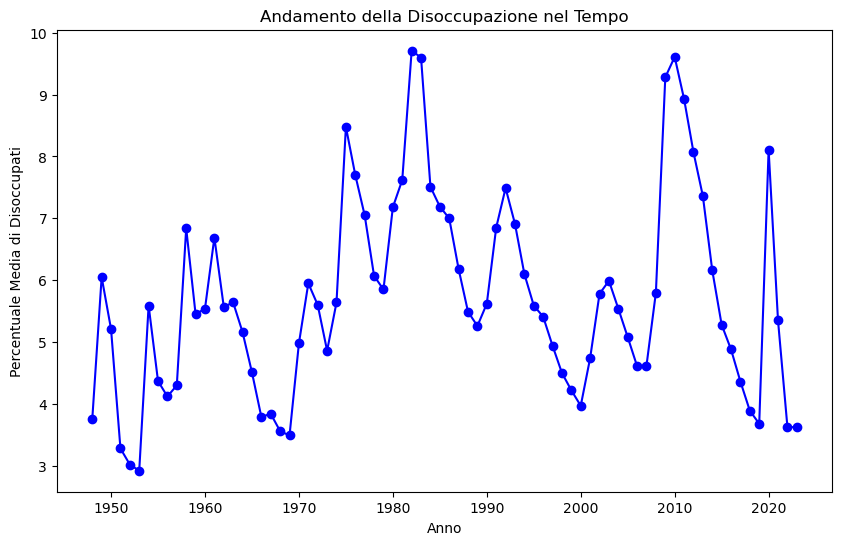

In [55]:
#Creiamo il grafico tramite Matplot
plt.figure(figsize=(10, 6))
plt.plot(df_employment['Anno'], df_employment['Percentuale_Media_Disoccupati'], marker='o', linestyle='-', color='b')


#Aggiungiamo titoli e etichette e visualizziamo
plt.title('Andamento della Disoccupazione nel Tempo')
plt.xlabel('Anno')
plt.ylabel('Percentuale Media di Disoccupati')
plt.show()

#### Andamento dei furti

Ora mostriamo come il numero di furti e scassi sono aumentati o diminuiti negli anni.

Come possiamo vedere i 'larceny theft', cioè i furti di beni personali di un'altra persona/azienda, hanno avuto un picco verso l'inizio degli anni 90. Invece gli altri sono andati a diminuire sempre nello stesso periodo.

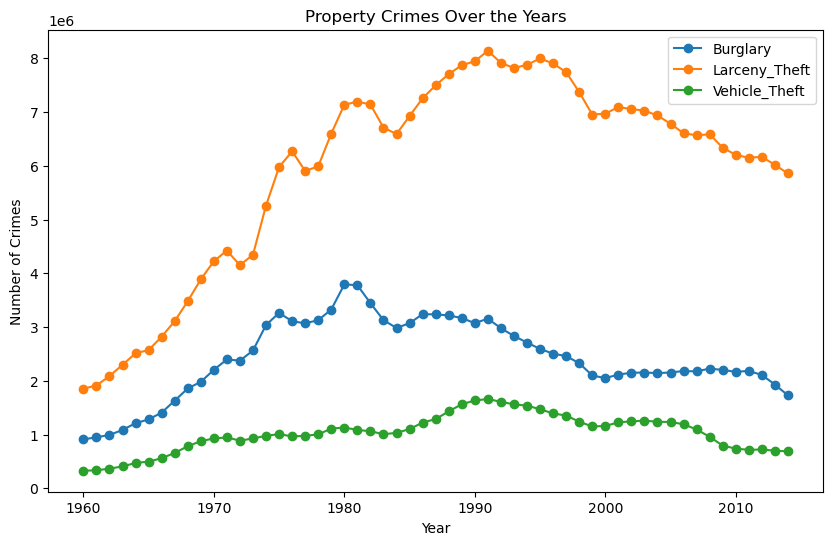

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(df_crime['Year'], df_crime['Burglary'], label='Burglary', marker='o')
plt.plot(df_crime['Year'], df_crime['Larceny_Theft'], label='Larceny_Theft', marker='o')
plt.plot(df_crime['Year'], df_crime['Vehicle_Theft'], label='Vehicle_Theft', marker='o')

plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Property Crimes Over the Years')
plt.legend()
plt.show()

#### Merge dei due Data Frame

Ora per confrontare al meglio i due data frame dobbiamo unirli

In [57]:
#Prima però modifichiamo df_employment perchè il suo range di dati è più ampio di df_crime
df_employment = df_employment.loc[(df_employment['Anno'] >= 1960) & (df_employment['Anno'] <= 2014)]


#E modifichiamo anche il nome della colonna 'Year' in df_crime
df_crime.columns = ['Anno', 'Population', 'Total', 'Violent', 'Property', 'Murder', 'Forcible_Rape', 'Robbery', 'Aggravated_assault', 'Burglary', 'Larceny_Theft', 'Vehicle_Theft'] 


#Ora possiamo unire i due data frame
df_merged = df_crime.merge(df_employment, on=['Anno'])


#Mostriamo il nuovo data frame
df_merged.head()

,Anno,Population,Total,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft,Percentuale_Media_Disoccupati
0,1960,179323175,3384200,288460,3095700,9110,17190,107840,154320,912100,1855400,328200,5.54
1,1961,182992000,3488000,289390,3198600,8740,17220,106670,156760,949600,1913000,336000,6.69
2,1962,185771000,3752200,301510,3450700,8530,17550,110860,164570,994300,2089600,366800,5.57
3,1963,188483000,4109500,316970,3792500,8640,17650,116470,174210,1086400,2297800,408300,5.64
4,1964,191141000,4564600,364220,4200400,9360,21420,130390,203050,1213200,2514400,472800,5.16


### Ora il momento che tutti aspettavamo...

andiamo a controllare se effettivamente c'è una correlazione fra i dati.

Nello specifico:
#### 1) Useremo il metodo .corr() per calcolare la correlazione fra le varie colonne

Ricordiamo che il metodo corr() calcola il coefficiente di correlazione lineare, il valore varia tra -1 e 1. 
Dove:
* -1 indica nessuna correlazione, anzi i valori hanno andamenti opposti;
* 1 indica una correlazione perfetta;
* 0 assenza di correlazione;


In [58]:
matriceDiCorr = df_merged[['Percentuale_Media_Disoccupati', 'Burglary', 'Larceny_Theft', 'Vehicle_Theft']].corr()
matriceDiCorr

,Percentuale_Media_Disoccupati,Burglary,Larceny_Theft,Vehicle_Theft
Percentuale_Media_Disoccupati,1.000000,0.422118,0.291155,-0.003237
Burglary,0.422118,1.000000,0.734091,0.690423
Larceny_Theft,0.291155,0.734091,1.000000,0.885326
Vehicle_Theft,-0.003237,0.690423,0.885326,1.000000


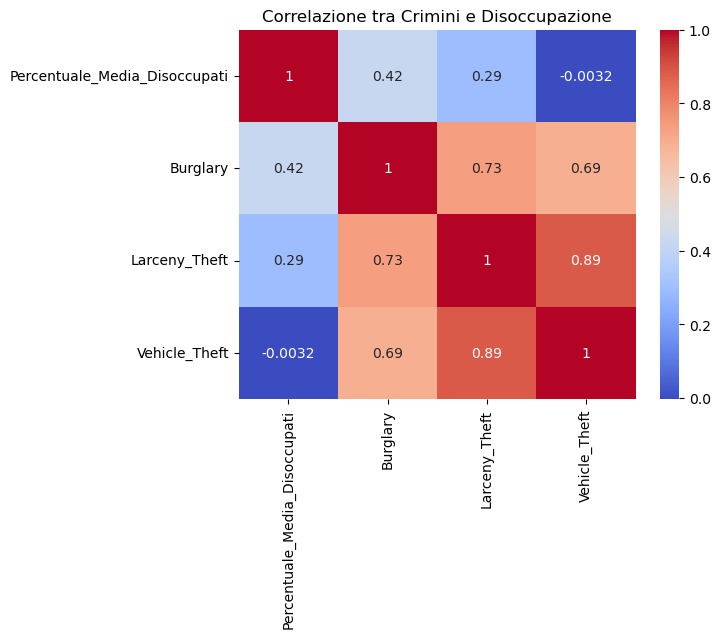

In [59]:
#Usiamo una heatmap per mostrare meglio i risultati
sns.heatmap(matriceDiCorr, annot=True, cmap='coolwarm')
plt.title('Correlazione tra Crimini e Disoccupazione')
plt.show()

#### Risultati punto 1...

I risultati ci mostrano che fra:
* media disoccupati e i furti con scasso (burglary): c'è una correlazione moderata positiva;
* media disoccupati e i furti di beni personali (larceny): c'è una correlazione leggermente positiva (meno forte della precedente);
* media disoccupati e i furti di auto: non c'è nessun tipo di correlazione

In conclusione è vero che un minimo di correlazione è presente ma comunque non mi sento in grado di affermare con certezze che all'umentare della disoccupazione aumentino anche i furti.

Gli altri risultati, anche se non interessanti ai nostri fini, sono tutti abbastanza correlati fra loro.

#### 2) Mostreremo i dati tramite scatter plot per vedere in maniera visiva una correlazione

Ora aggiungiamo una nuova colonna al data frame (Total_Theft), che conterrà tutta la somma dei furti, in questo modo possiamo vedere se c'è un'effettiva correlazione.

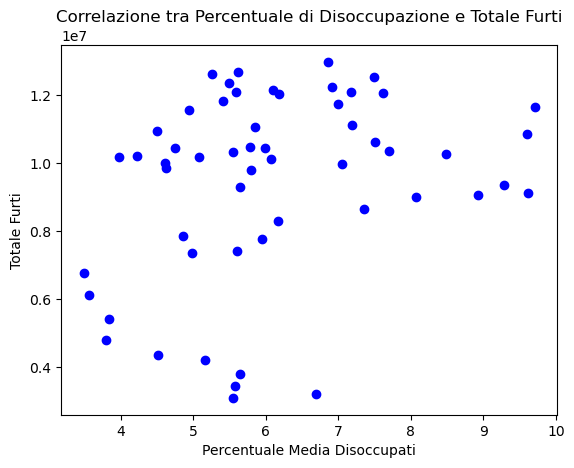

In [60]:
# Calcolo somma dei furti
df_merged['Total_Theft'] = df_merged['Burglary'] + df_merged['Larceny_Theft'] + df_merged['Vehicle_Theft']


# Creazione scatter plot
plt.scatter(df_merged['Percentuale_Media_Disoccupati'], df_merged['Total_Theft'], color='blue')


#Aggiunta etichette, titolo e mostriamo il plot
plt.xlabel('Percentuale Media Disoccupati')
plt.ylabel('Totale Furti')
plt.title('Correlazione tra Percentuale di Disoccupazione e Totale Furti')
plt.show()

#### Risultati punto 2...

Lo scatter plot ci mostra come non è presente una correlazione fra i furti e l'aumentar della disoccupazione, infatti i valori sono distanti fra loro e non seguono una direzione precisa.

# Parte Filo

In [245]:
df = pd.read_csv("CSV3.csv")
df

,date,overall_rate,men_rate,women_rate,men_16_17_rate,women_16_17_rate,men_16_19_rate,women_16_19_rate,men_18_19_rate,women_18_19_rate,...,men_25_34_rate,women_25_34_rate,men_25_54_rate,women_25_54_rate,men_35_44_rate,women_35_44_rate,men_45_54_rate,women_45_54_rate,men_55plus_rate,women_55plus_rate
0,1948-01-01,3.4,3.4,3.3,9.7,8.8,9.4,7.2,9.5,6.8,...,2.6,4.3,2.3,2.8,2.1,1.8,2.3,2.1,3.0,NaN
1,1948-02-01,3.8,3.6,4.5,13.0,13.2,10.8,8.9,9.2,6.8,...,2.7,5.1,2.6,3.7,2.5,2.6,2.6,3.3,2.9,NaN
2,1948-03-01,4.0,3.8,4.4,14.0,11.4,11.9,8.6,10.3,7.3,...,2.7,3.5,2.6,3.3,2.6,3.0,2.4,3.3,2.8,NaN
3,1948-04-01,3.9,3.8,4.3,11.6,10.6,9.8,9.2,8.6,8.6,...,3.2,3.8,2.8,3.5,2.7,3.5,2.5,3.1,2.9,NaN
4,1948-05-01,3.5,3.5,3.7,7.1,5.4,7.6,6.1,8.6,7.0,...,2.9,3.3,2.5,3.1,2.4,3.0,2.3,2.9,3.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,2023-08-01,3.8,4.0,3.5,12.1,11.8,13.8,10.7,15.2,10.3,...,3.9,3.9,3.2,3.0,3.0,2.9,2.8,2.2,2.8,2.6
908,2023-09-01,3.8,4.1,3.4,15.4,10.1,12.7,10.8,11.4,10.8,...,4.6,3.3,3.6,2.8,3.0,2.5,3.1,2.4,2.5,2.7
909,2023-10-01,3.8,4.1,3.6,16.3,13.1,14.6,11.7,14.2,10.8,...,4.6,3.7,3.4,3.0,3.0,2.9,2.6,2.2,2.7,2.8
910,2023-11-01,3.7,4.0,3.4,13.3,9.5,12.2,10.6,11.7,11.2,...,4.2,3.5,3.4,2.9,3.2,2.5,2.7,2.5,3.3,2.6


In [246]:
df_employment = pd.read_csv("CSV2.csv")
df_employment

,date,overall_rate,age_16_17_rate,age_16_19_rate,age_18_19_rate,age_16_24_rate,age_20_24_rate,age_25_34_rate,age_25_54_rate,age_35_44_rate,age_45_54_rate,age_20plus_rate,age_25plus_rate,age_55plus_rate
0,1948-01-01,3.4,9.4,8.5,8.3,6.8,5.8,3.0,2.5,2.0,2.2,3.0,2.6,2.9
1,1948-02-01,3.8,13.1,10.0,8.2,7.7,6.3,3.3,2.9,2.5,2.8,3.3,2.9,3.1
2,1948-03-01,4.0,13.0,10.5,8.9,8.7,7.6,2.9,2.8,2.7,2.6,3.5,2.8,3.0
3,1948-04-01,3.9,11.2,9.5,8.6,7.8,6.8,3.4,3.0,2.9,2.6,3.5,3.0,3.0
4,1948-05-01,3.5,6.5,7.0,7.9,6.7,6.6,3.0,2.7,2.6,2.4,3.3,2.8,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,2023-08-01,3.8,11.9,12.3,12.7,8.6,7.1,3.9,3.1,3.0,2.5,3.4,3.0,2.7
908,2023-09-01,3.8,12.8,11.8,11.1,8.4,7.0,4.0,3.2,2.8,2.8,3.5,3.0,2.7
909,2023-10-01,3.8,14.7,13.1,12.5,8.8,7.0,4.2,3.2,2.9,2.4,3.5,3.1,2.7
910,2023-11-01,3.7,11.4,11.4,11.5,8.0,6.6,3.9,3.1,2.9,2.6,3.4,3.1,2.9


Si vuole analizzare nei due sessi è colpito di più dalla disoccupazione nel corso degli anni

In [247]:
df = df.drop(columns=['men_16_17_rate',	'women_16_17_rate',	'men_16_19_rate',	'women_16_19_rate',	'men_18_19_rate',	'women_18_19_rate', 'men_16_24_rate',	'women_16_24_rate',	'men_20_24_rate',	'women_20_24_rate',	'men_25plus_rate',	'women_25plus_rate',	'men_25_34_rate',	'women_25_34_rate',	'men_25_54_rate', 'women_25_54_rate', 'men_35_44_rate', 'women_35_44_rate',	'men_45_54_rate',	'women_45_54_rate',	'men_55plus_rate',	'women_55plus_rate'])


df['date'] = pd.to_datetime(df['date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          912 non-null    datetime64[ns]
 1   overall_rate  912 non-null    float64       
 2   men_rate      912 non-null    float64       
 3   women_rate    912 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 28.6 KB


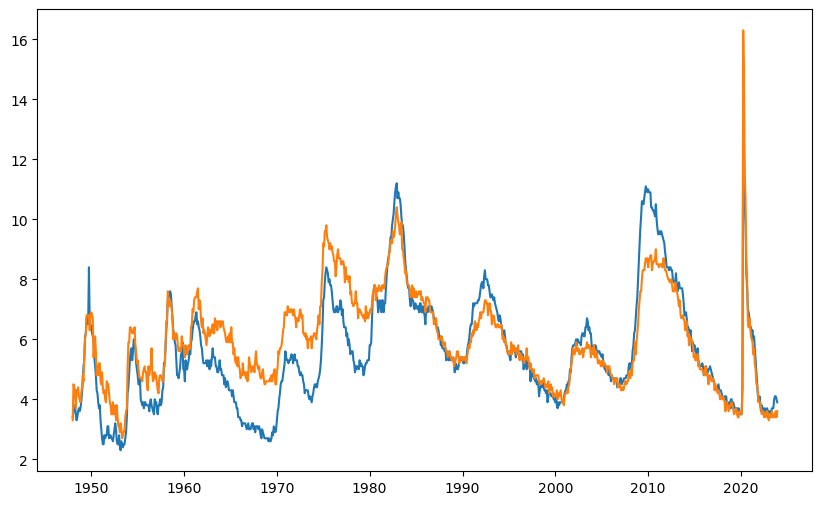

In [248]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['men_rate'], label='uomini')
plt.plot(df['date'], df['women_rate'], label='donne')

Da questo grafico è difficile estrapolare informazioni per effettuare un confronto tra disoccupazione maschile e quella femminile, in quanto le curve nel tempo si sovrappongono più volte. Per questo motivo viene calcolato il valore medio della disoccupazione maschile e femminile nell'arco temporale considerato (dal 48 al 2023)

In [249]:
percentualeMediaMaschi=df['men_rate'].mean().round(2)
percentualeMediaDonne=df['women_rate'].mean().round(2)
percentualeMediaTot=df['overall_rate'].mean().round(2)

In [250]:
print(percentualeMediaMaschi)

5.58


In [251]:
print(percentualeMediaDonne)

5.96


In [252]:
print(percentualeMediaTot)

5.7


Da questi valori che nell'arco temporale considerato, in termine di valore medio la percentuale di donne disoccupate è stato maggiore degli uomini disoccupati

Si vuole ora analizzare l'andamento della disoccupazione giovanile nel corso degli anni. Per fare ciò, si considerano i tassi di disoccupazione complessivi, ossia riferiti all'intera popolazione senza distinguere tra uomini e donne, dei ragazzi avente età tra 16 e 24 anni.

In [253]:
df_employment['date'] = pd.to_datetime(df_employment['date'])
df_employment['Disoccupati16_24'] = (df_employment['age_16_24_rate'])
df_employment['Disoccupati25plus'] = (df_employment['age_25plus_rate'])


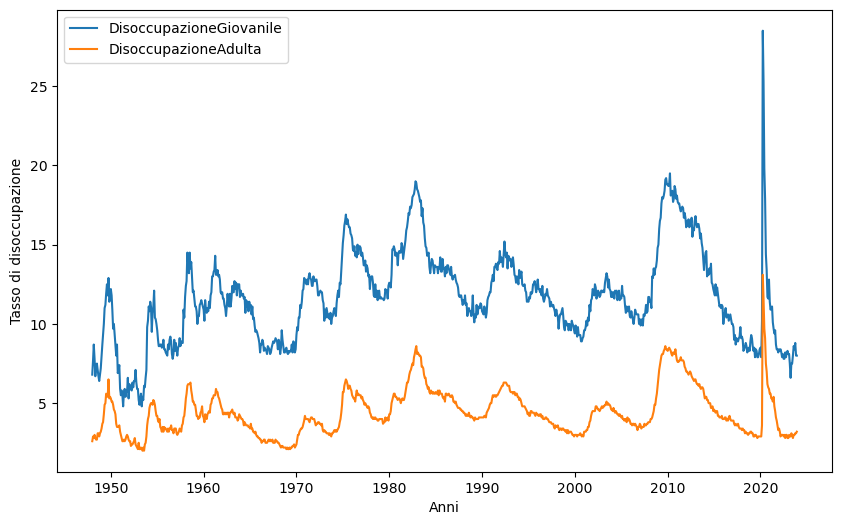

In [254]:
plt.figure(figsize=(10, 6))
plt.plot(df_employment['date'], df_employment['Disoccupati16_24'], label='DisoccupazioneGiovanile')
plt.plot(df_employment['date'], df_employment['Disoccupati25plus'], label='DisoccupazioneAdulta')


plt.xlabel('Anni')
plt.ylabel('Tasso di disoccupazione')
plt.legend()
plt.show()

Risulta evidente che negli anni il trend di disocupazione giovanile sia maggiore di quello relativo a persone di età più mature.